In [1]:
# Import necessary libraries
!pip install -q supervision ultralytics opencv-python-headless


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.7/135.7 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 825.4/825.4 kB 49.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 24.2 MB/s eta 0:00:00


In [2]:
import cv2
import numpy as np
import supervision as sv
from tqdm import tqdm
from ultralytics import YOLO
from collections import defaultdict, deque


In [6]:
# Define constants
SOURCE_VIDEO_PATH = "/content/vehi_1.mp4"  # Update this with your video file path
TARGET_VIDEO_PATH = "video_result_1.mp4"
CONFIDENCE_THRESHOLD = 0.3
IOU_THRESHOLD = 0.5
MODEL_NAME = "yolov8x.pt"
MODEL_RESOLUTION = 1024
SOURCE = np.array([
    [0, 200],
    [1250, 200],
    [1250, 500],
    [-0, 500]
])

TARGET_WIDTH = 7
TARGET_HEIGHT = 2.2


In [7]:
TARGET = np.array([
    [0, 0],
    [TARGET_WIDTH - 1, 0],
    [TARGET_WIDTH - 1, TARGET_HEIGHT - 1],
    [0, TARGET_HEIGHT - 1],
])


In [8]:
# Initialize frame generator and get the first frame for annotation
frame_generator = sv.get_video_frames_generator(source_path=SOURCE_VIDEO_PATH)
frame_iterator = iter(frame_generator)
frame = next(frame_iterator)


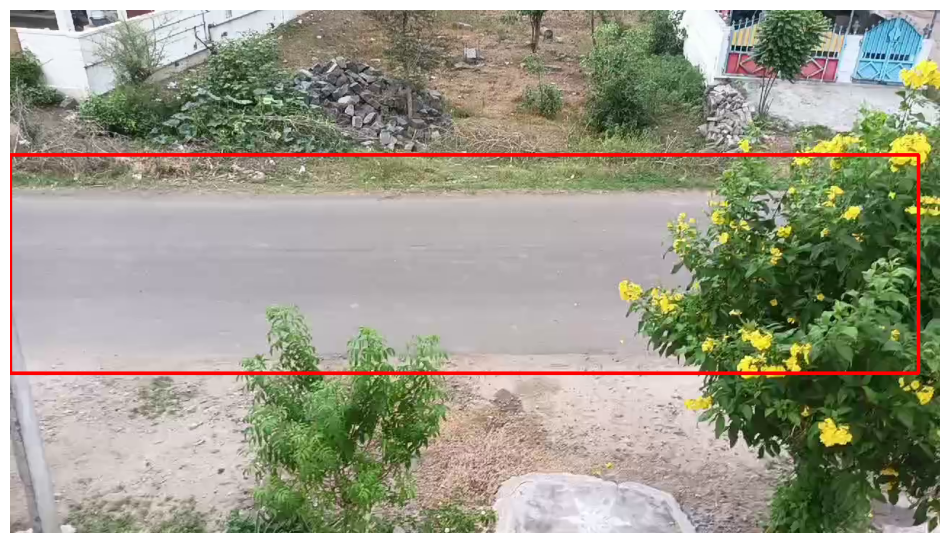

In [9]:
import numpy as np
from supervision import Color, draw_polygon, plot_image

red_color = Color(255, 0, 0)  # RGB for red


#SOURCE = [[10, 10], [100, 10], [100, 100], [10, 100]]

polygon = np.array(SOURCE, dtype=np.int32).reshape((-1, 1, 2))

# Draw the polygon on the frame
annotated_frame = frame.copy()
annotated_frame = draw_polygon(scene=annotated_frame, polygon=polygon, color=red_color, thickness=4)

plot_image(annotated_frame)

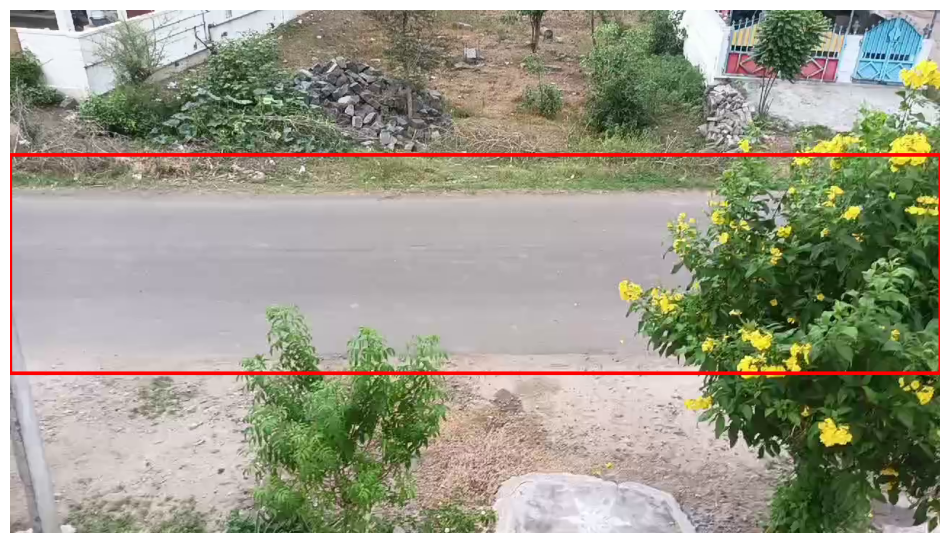

In [10]:
import numpy as np
from supervision import Color, draw_polygon, plot_image

red_color = Color(255, 0, 0)  # RGB for red


#SOURCE = [[10, 10], [100, 10], [100, 100], [10, 100]]

polygon = np.array(SOURCE, dtype=np.int32).reshape((-1, 1, 2))

# Draw the polygon on the frame
annotated_frame = frame.copy()
annotated_frame = draw_polygon(scene=annotated_frame, polygon=polygon, color=red_color, thickness=4)

plot_image(annotated_frame)

In [10]:
class ViewTransformer:

    def __init__(self, source: np.ndarray, target: np.ndarray) -> None:
        source = source.astype(np.float32)
        target = target.astype(np.float32)
        self.m = cv2.getPerspectiveTransform(source, target)

    def transform_points(self, points: np.ndarray) -> np.ndarray:
        if points.size == 0:
            return points

        reshaped_points = points.reshape(-1, 1, 2).astype(np.float32)
        transformed_points = cv2.perspectiveTransform(reshaped_points, self.m)
        return transformed_points.reshape(-1, 2)


In [11]:
view_transformer = ViewTransformer(source=SOURCE, target=TARGET)

In [12]:
model = YOLO(MODEL_NAME)

video_info = sv.VideoInfo.from_video_path(video_path=SOURCE_VIDEO_PATH)
frame_generator = sv.get_video_frames_generator(source_path=SOURCE_VIDEO_PATH)



100%|██████████| 131M/131M [00:00<00:00, 255MB/s]


In [13]:
# Tracer initiation
byte_track = sv.ByteTrack(frame_rate=video_info.fps, track_thresh=CONFIDENCE_THRESHOLD)

# Annotators configuration
thickness = sv.calculate_optimal_line_thickness(
    resolution_wh=video_info.resolution_wh)
text_scale = sv.calculate_optimal_text_scale(resolution_wh=video_info.resolution_wh)
bounding_box_annotator = sv.BoundingBoxAnnotator(thickness=thickness)
label_annotator = sv.LabelAnnotator(text_scale=text_scale, text_thickness=thickness, text_position=sv.Position.BOTTOM_CENTER)
trace_annotator = sv.TraceAnnotator(thickness=thickness, trace_length=video_info.fps * 2, position=sv.Position.BOTTOM_CENTER)

polygon_zone = sv.PolygonZone(polygon=SOURCE, frame_resolution_wh=video_info.resolution_wh)
coordinates = defaultdict(lambda: deque(maxlen=video_info.fps))



# Open target video
with sv.VideoSink(TARGET_VIDEO_PATH, video_info) as sink:
    for frame in tqdm(frame_generator, total=video_info.total_frames):
        result = model(frame, imgsz=MODEL_RESOLUTION, verbose=False)[0]
        detections = sv.Detections.from_ultralytics(result)

        detections = detections[detections.confidence > CONFIDENCE_THRESHOLD]
        detections = detections[detections.class_id != 0]
        detections = detections[polygon_zone.trigger(detections)]
        detections = detections.with_nms(IOU_THRESHOLD)

        detections = byte_track.update_with_detections(detections=detections)
        points = detections.get_anchors_coordinates(anchor=sv.Position.BOTTOM_CENTER)
        points = view_transformer.transform_points(points=points).astype(int)

        for tracker_id, (x, y) in zip(detections.tracker_id, points):
            coordinates[tracker_id].append((x, y))

        labels = []
        for tracker_id in detections.tracker_id:
            if len(coordinates[tracker_id]) < video_info.fps / 2:
                labels.append(f"#{tracker_id}")
            else:
                (x_start, y_start) = coordinates[tracker_id][-1]
                (x_end, y_end) = coordinates[tracker_id][0]
                distance = ((x_start - x_end) ** 2 + (y_start - y_end) ** 2) ** 0.5
                time = len(coordinates[tracker_id]) / video_info.fps
                speed = distance / time * 3.6
                labels.append(f"#{tracker_id} {int(speed)} km/h")

        annotated_frame = frame.copy()
        annotated_frame = trace_annotator.annotate(scene=annotated_frame, detections=detections)
        annotated_frame = bounding_box_annotator.annotate(scene=annotated_frame, detections=detections)
        annotated_frame = label_annotator.annotate(scene=annotated_frame, detections=detections, labels=labels)

        sink.write_frame(annotated_frame)



SupervisionWarnings: `track_thresh` in `ByteTrack.__init__` is deprecated and will be remove in `supervision-0.23.0`. Use 'track_activation_threshold' instead.
SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
SupervisionWarnings: The `frame_resolution_wh` parameter is no longer required and will be dropped in version supervision-0.24.0. The mask resolution is now calculated automatically based on the polygon coordinates.
100%|██████████| 225/225 [00:25<00:00,  8.84it/s]
